<a href="https://colab.research.google.com/github/hanselkane/MachineLearning-Telyu/blob/main/Week%205/ML_Telyu_Week_5_EDA_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install kaggle
# Make a directory to store kaggle token
!mkdir ~/.kaggle # the '~' symbol is equal '/root'

import json
token ={"username":"ultranumb","key":"5f6e16afa53809c7c1817b1bb3f3242b"}
json_object = json.dumps(token, indent = 4)
  
# Writing to kaggle.json
with open("/root/.kaggle/kaggle.json", "w") as outfile:
    outfile.write(json_object)

!chmod 600 ~/.kaggle/kaggle.json # Changing permission access to kaggle.json

In [5]:
!kaggle competitions download santander-customer-transaction-prediction

 96% 241M/250M [00:05<00:00, 41.4MB/s]
100% 250M/250M [00:05<00:00, 46.6MB/s]


In [6]:
!unzip santander-customer-transaction-prediction.zip

Archive:  santander-customer-transaction-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

In [8]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [9]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
print(features)

['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95', 'var_96', 'var_97', 'var_98', 'var_99', 'var_100'

In [10]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [12]:
train.shape

(200000, 202)

In [13]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [14]:
#Check for Missing Values after Concatination

obs = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
ID_code,0,0.0
var_136,0,0.0
var_126,0,0.0
var_127,0,0.0
var_128,0,0.0
...,...,...
var_68,0,0.0
var_69,0,0.0
var_70,0,0.0
var_71,0,0.0


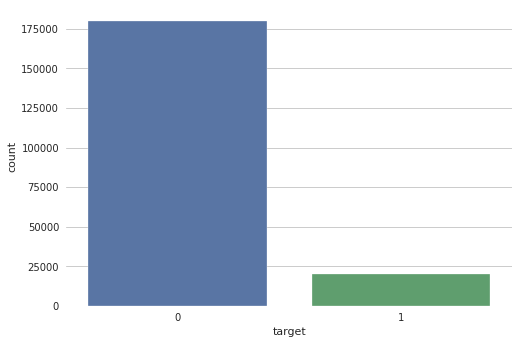

In [15]:
target = train['target']
train = train.drop(["ID_code", "target"], axis=1)
sns.set_style('whitegrid')
sns.countplot(target)

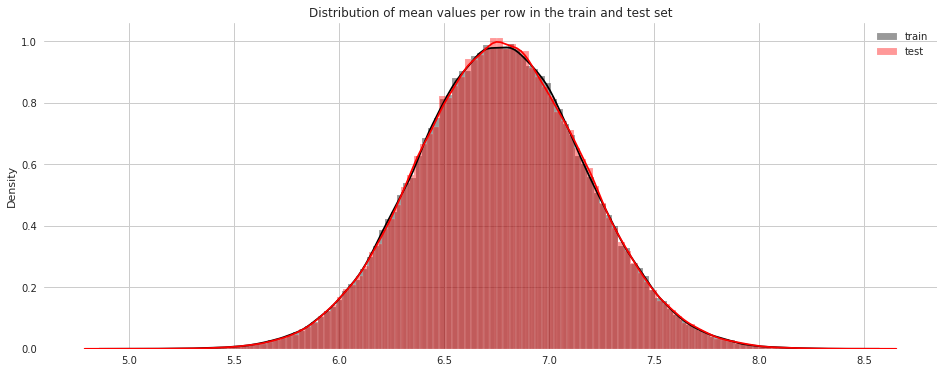

In [16]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

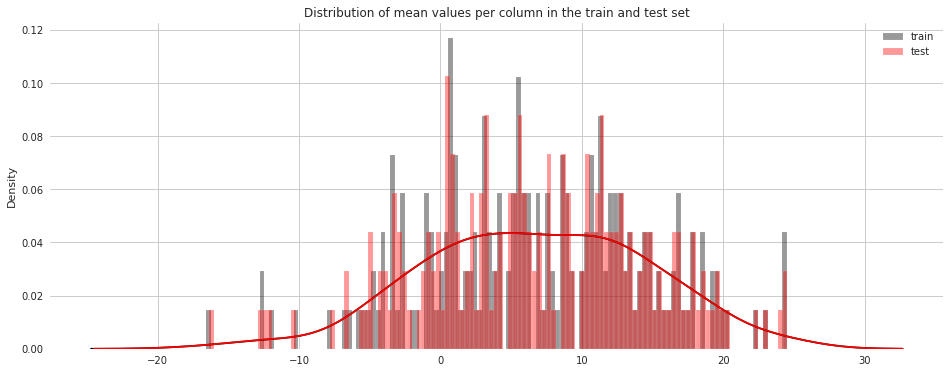

In [17]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

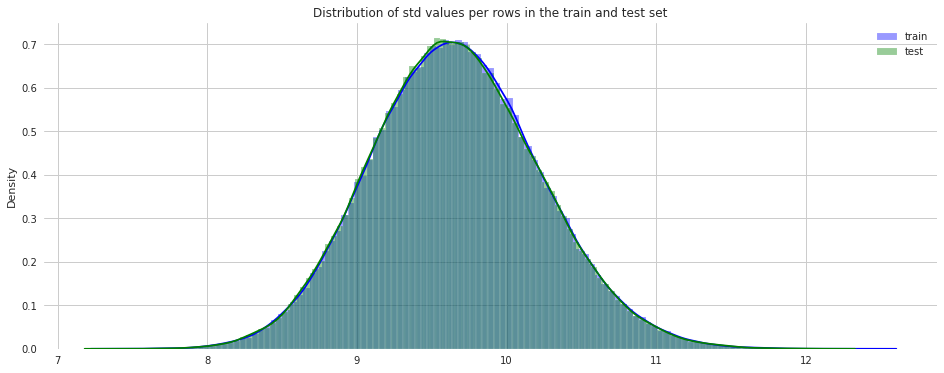

In [18]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per rows in the train and test set")
sns.distplot(train[features].std(axis=1),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

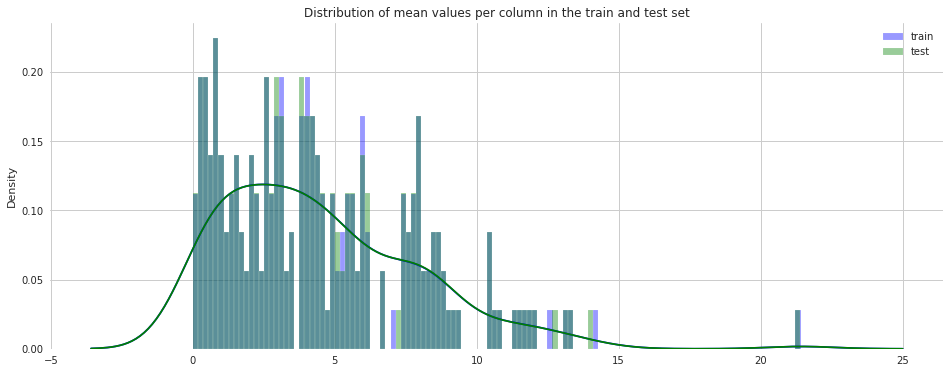

In [19]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend();plt.show()

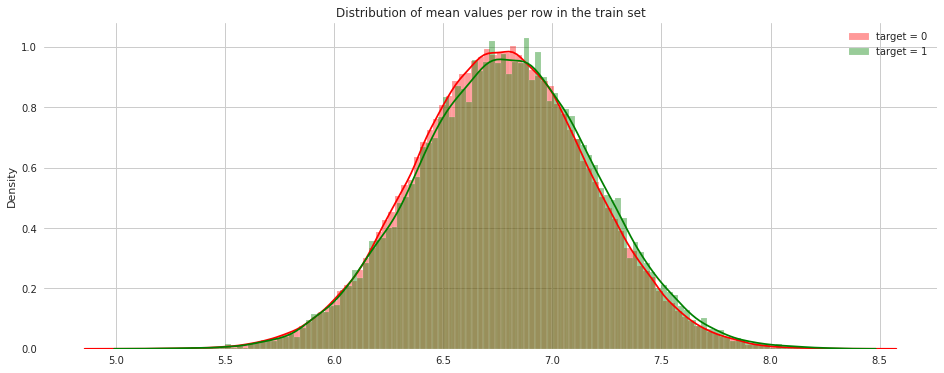

In [20]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

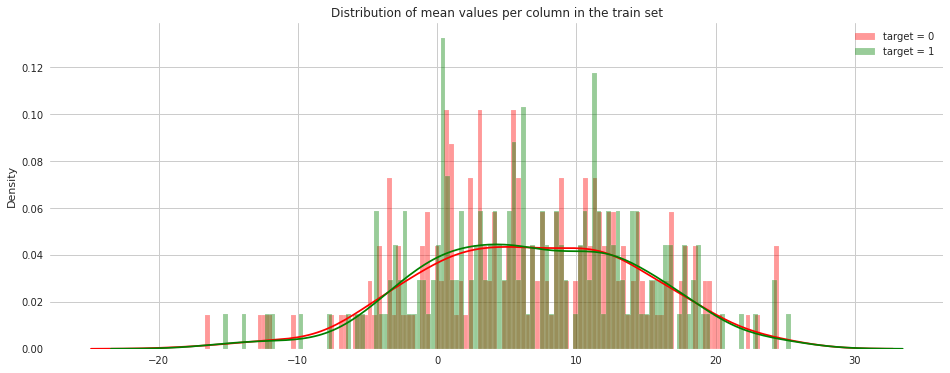

In [21]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

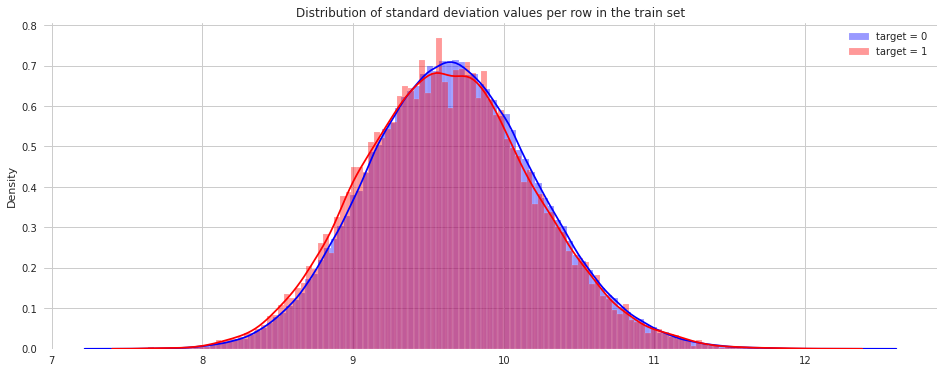

In [22]:
# Check the std of every row
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per row in the train set")
sns.distplot(t0[features].std(axis=1),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=1),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

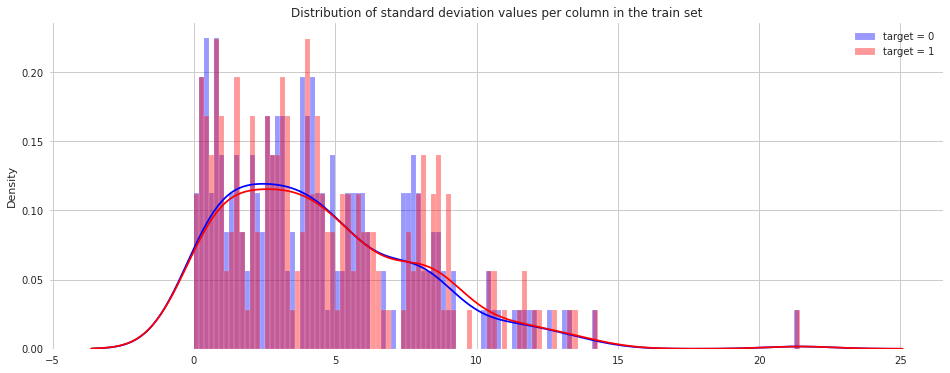

In [23]:
t0 = train.loc[target  == 0]
t1 = train.loc[target  == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per column in the train set")
sns.distplot(t0[features].std(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=0),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

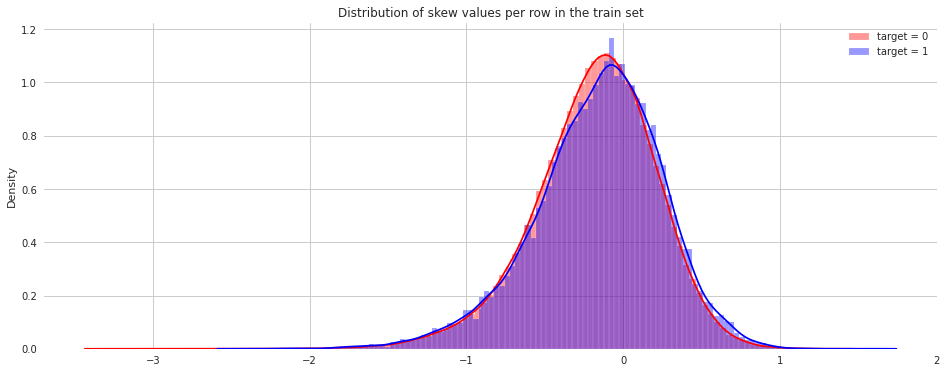

In [24]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

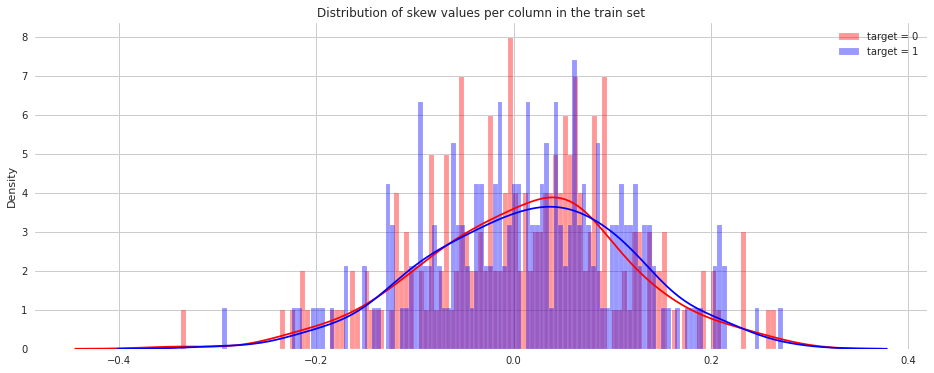

In [25]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

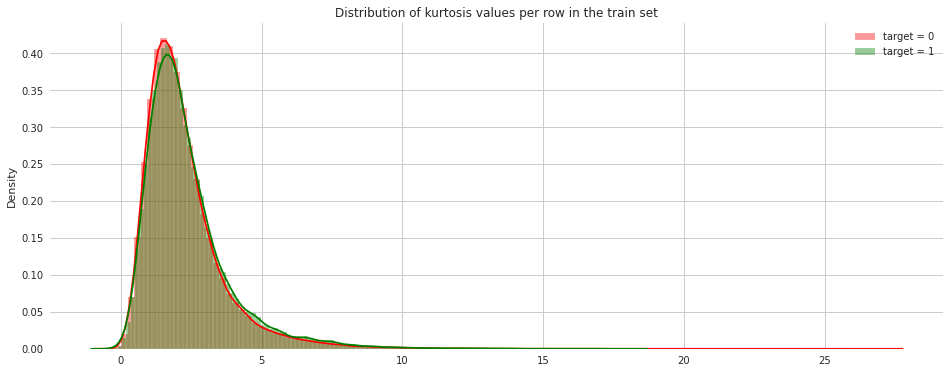

In [26]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

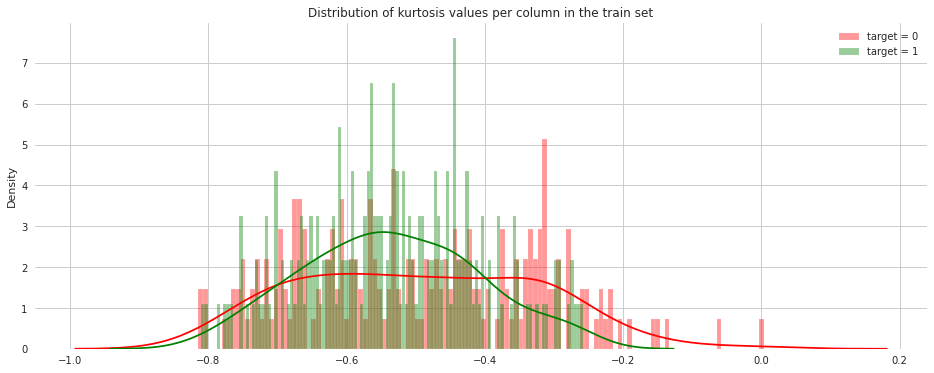

In [27]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

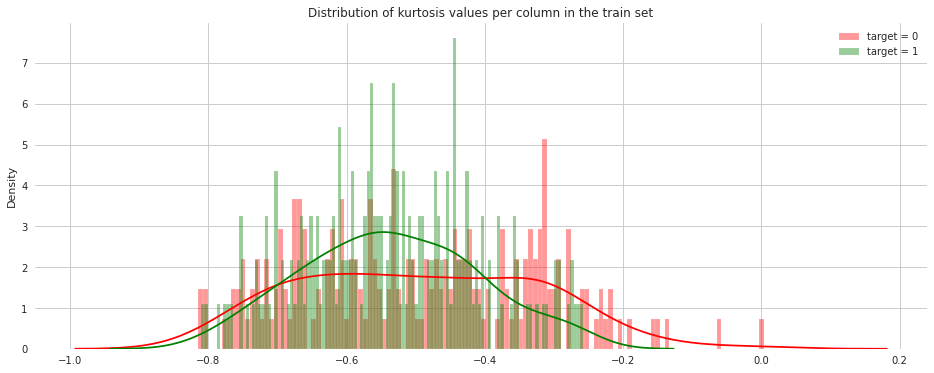

In [28]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

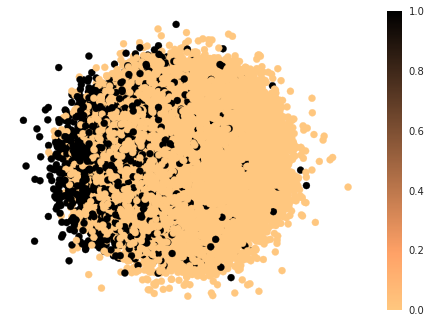

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

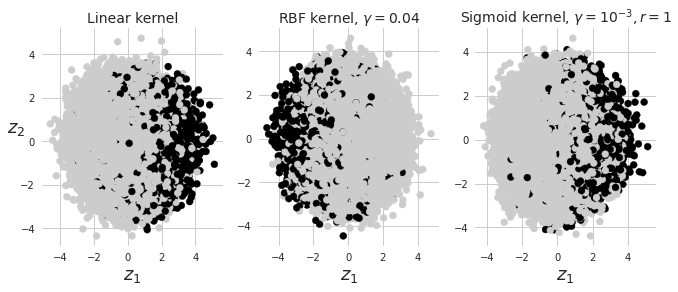

In [30]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [31]:
# Make dummy data by partially copying the existing data
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [36]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'shuffle':'true'
}

In [33]:
train.shape

(200000, 200)

In [42]:
num_folds = 11
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=2319, shuffle=True)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 500000, valid_sets = [trn_data, val_data], verbose_eval=1, early_stopping_rounds = 1)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
[1]	training's auc: 0.580513	valid_1's auc: 0.568401
Training until validation scores don't improve for 1 rounds.
[2]	training's auc: 0.628299	valid_1's auc: 0.610648
[3]	training's auc: 0.659932	valid_1's auc: 0.645938
[4]	training's auc: 0.682919	valid_1's auc: 0.667449
[5]	training's auc: 0.686996	valid_1's auc: 0.66935
[6]	training's auc: 0.703997	valid_1's auc: 0.683989
[7]	training's auc: 0.725225	valid_1's auc: 0.70326
[8]	training's auc: 0.730326	valid_1's auc: 0.708249
[9]	training's auc: 0.733857	valid_1's auc: 0.712673
[10]	training's auc: 0.735788	valid_1's auc: 0.714718
[11]	training's auc: 0.743182	valid_1's auc: 0.722729
[12]	training's auc: 0.745765	valid_1's auc: 0.727235
[13]	training's auc: 0.754775	valid_1's auc: 0.734778
[14]	training's auc: 0.759831	valid_1's auc: 0.741085
[15]	training's auc: 0.767998	valid_1's auc: 0.748066
[16]	training's auc: 0.776987	valid_1's auc: 0.756593
[17]	training's auc: 0.780728	valid_1's auc: 0.760951
[18]	

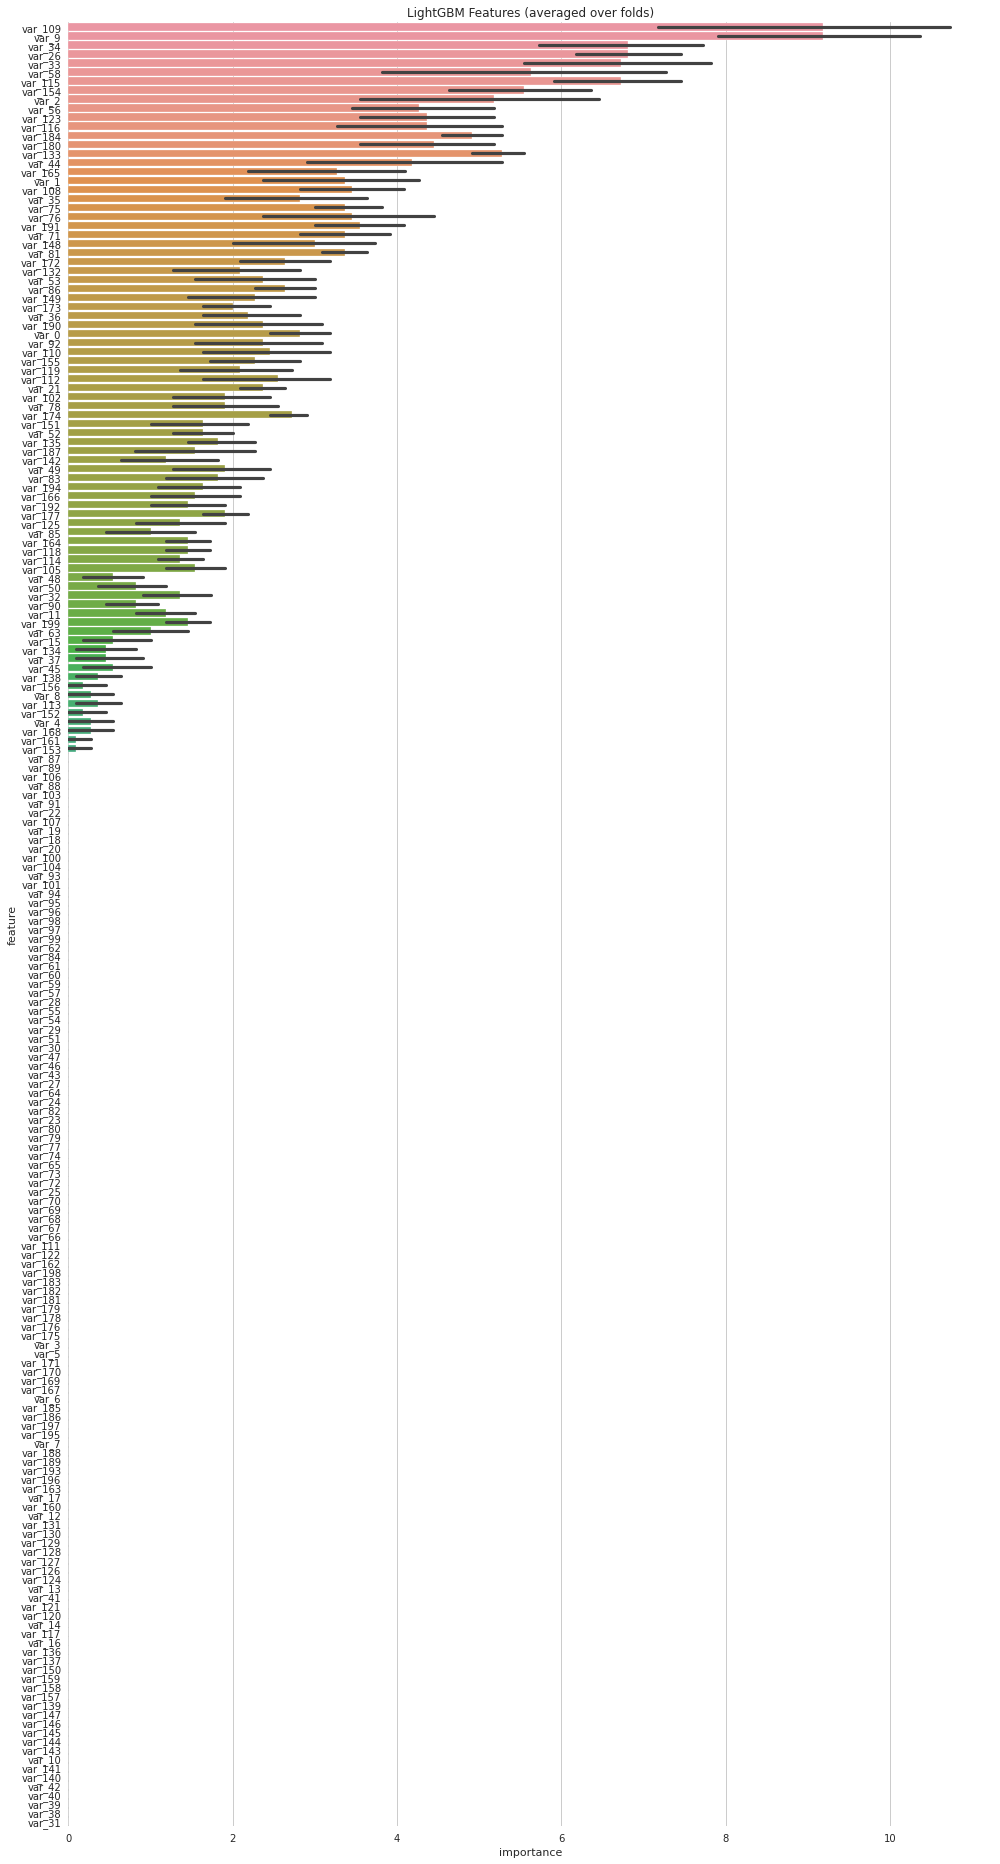

In [43]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')